## Nitrate, compare 202111 to 201905R

In [2]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools

Bot data from 2011 - 2019  
PSF data from 2015 - 2017  
PUG data from 2015 - 2017

In [83]:
field = 'Nitrate'
obsn = 'N'
modn = 'mod_nitrate'
vmax = 40
vmin = 0
dbin = 2
scale = 28

cmap = 'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [67]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [68]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [69]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [70]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [71]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [72]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [73]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [74]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [75]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [76]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    if ('NO23' in temp1.columns):
        if ('N' in temp1.columns):
            temp1['N'] = temp1.N.fillna(value=temp1['NO23'])
        else:
            temp1['N'] = temp1['NO23']
    return temp1

In [77]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth) & (temp1[obsn] == temp1[obsn])]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts


In [78]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [79]:
def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = 'SY' #years[0] #min(years[0], years_psf[0], years_pug[0])#, years_onc[0])
    endyear = 'EY' #years[-1] #max(years[-1], years_psf[-1], years_pug[-1])#, years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv')
    for year in years_psf:
        pieces1.append(
            f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d201905, counts1 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)
    
    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts2 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1], whichdepths, reverse, string)

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lcccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether, counts1, counts2

## All Depths

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,14468,-1.15,4.27,4.11,0.0702,0.108,1.25,1.49,3.81,0.183
202111,14465,-0.916,4.03,3.92,0.0641,0.137,2.13,1.5,3.51,0.231


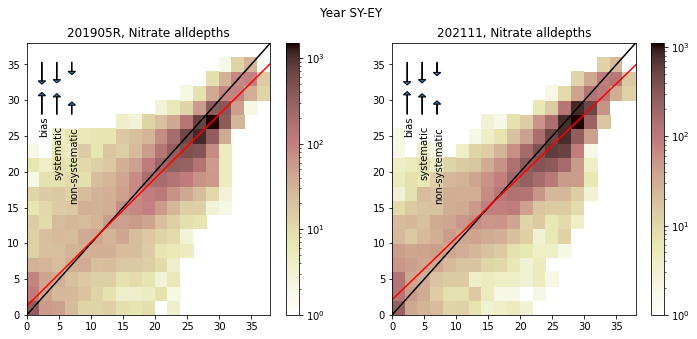

In [84]:
idepth = 0
jdepth = 39

results, counts1, counts2 = plot_allyears([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017]
                                       , [] #   , [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , [] #   , [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')
results.style.format(myformat).apply(highlight_max_min)

## Top 5 m

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2633,-0.625,6.29,6.25,0.121,0.174,1.57,1.85,5.55,0.259
202111,2630,-0.598,6.05,6.02,0.122,0.257,2.65,2.63,4.87,0.379


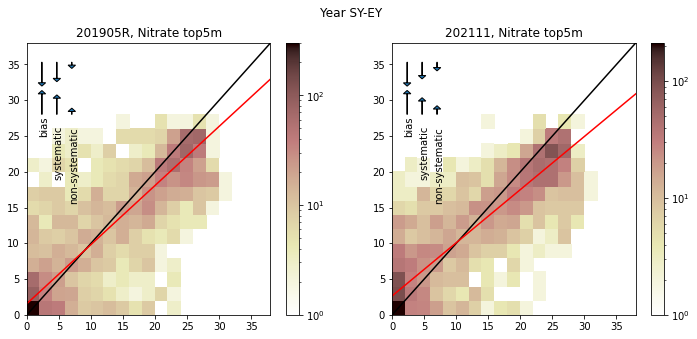

In [86]:
idepth = 0
jdepth = 5

results, counts1, counts2 = plot_allyears([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                            , [2015]
                                          , [2015, 2016, 2017]
                                       , [] 
                                       , [], 
                                          idepth, jdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

## Below 5 m

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,11835,-1.27,3.68,3.45,0.0886,0.114,1.5,1.48,3.19,0.187
202111,11835,-0.987,3.42,3.28,0.0795,0.153,2.73,1.42,2.91,0.251


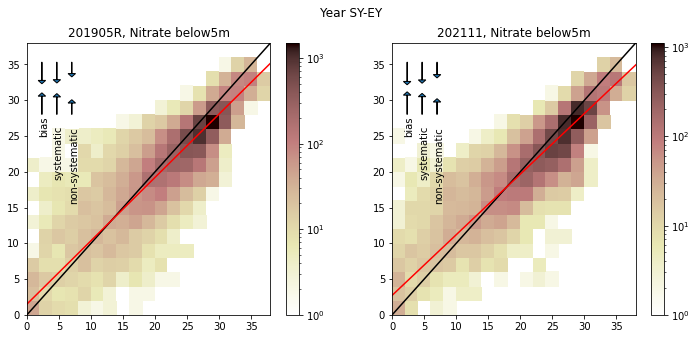

In [87]:
idepth = 5
jdepth = 39

results, counts1, counts2 = plot_allyears([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                            , [2015]
                                          , [2015, 2016, 2017]
                                       , [] 
                                       , [], 
                                          idepth, jdepth, 'below5m')
results.style.format(myformat).apply(highlight_max_min)

# Regionals

In [88]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [89]:
def stats_allregions(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths):
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')    
    temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(temp1, '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(temp1, '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(temp2, '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccccl', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    f.close()
    return number, alltogether

In [90]:
def stats_and_plot(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')   
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)
    
    alltogether, counts = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psf_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pug_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)
    
    
    alltogether = pd.concat([alltogether, d202111], axis=0)

In [91]:
def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
    ks = (select.groupby('k')[obsn].mean().index[:])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[ks], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:blue', label='201905')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3]) &
                              (temp2[obsn] == temp2[obsn])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:orange', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[ks], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [92]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

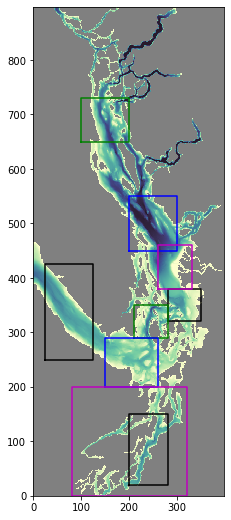

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'g')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'b')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'k')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'k')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
SS_all = [0, 898, 0, 398]
boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
           'JdF_west', 'JdF_east']
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')

## All Depths

In [94]:
idepth = 0
jdepth = 39

number, results = stats_allregions([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], 
                           [],
                           idepth, jdepth, 'alldepths')
for boxname in boxnames:
    if number > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,14468,-1.15,4.27,4.11,0.0702,0.108,1.25,1.49,3.81,0.141
202111,14465,-0.916,4.03,3.92,0.0641,0.137,2.13,1.5,3.51,0.195


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,800,-1.72,2.95,2.4,0.0859,0.0112,-1.45,1.72,2.39,-0.00379
202111,800,-1.44,2.7,2.28,0.0775,0.0973,0.854,1.53,2.12,0.15


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2060,-0.881,3.55,3.44,0.0473,0.11,1.69,1.3,3.14,0.0779
202111,2060,-0.637,3.24,3.18,0.0397,0.123,2.25,1.25,2.82,0.109


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1203,-0.387,3.96,3.95,0.0617,0.133,2.6,1.22,3.55,0.17
202111,1203,0.0708,3.81,3.81,0.0608,0.199,4.54,1.73,3.11,0.291


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,396,-3.63,6.23,5.07,0.18,0.183,-0.17,3.92,4.46,0.271
202111,396,-3.36,6.82,5.93,0.218,0.205,0.519,3.74,5.2,0.274


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,723,-1.88,2.76,2.02,0.119,-0.0536,-3.16,1.89,2.07,-0.191
202111,723,-1.4,2.43,1.98,0.104,0.0656,0.162,1.43,1.91,0.0387


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,952,-1.1,4.76,4.63,0.118,0.106,1.63,1.36,4.34,0.168
202111,952,-0.832,3.94,3.86,0.0831,0.156,3.19,1.44,3.42,0.27


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,997,-1.5,3.08,2.69,0.135,0.0286,-0.812,1.51,2.65,0.017
202111,997,-1.26,2.74,2.43,0.11,0.0762,0.58,1.3,2.32,0.11


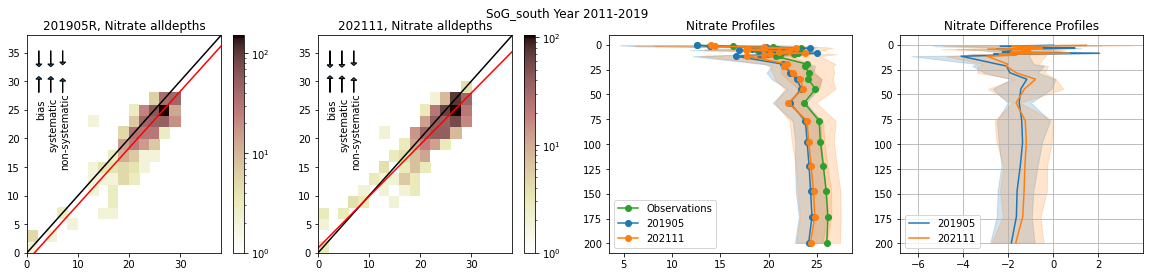

In [95]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], 
               [], 
               [],
               idepth, jdepth, SoG_south, 'SoG_south', 'alldepths')

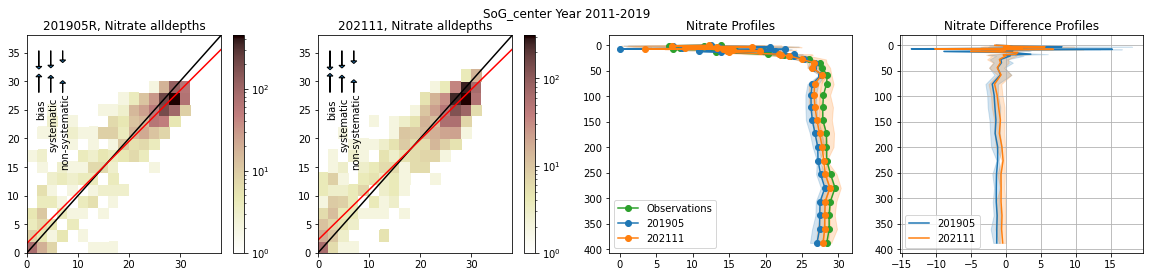

In [96]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], 
               [],
               idepth, jdepth, SoG_center, 'SoG_center', 'alldepths')

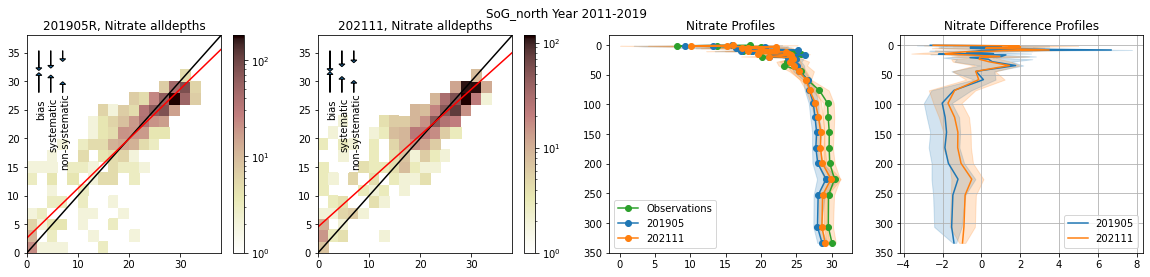

In [97]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], [],
               idepth, jdepth, SoG_north, 'SoG_north', 'alldepths')

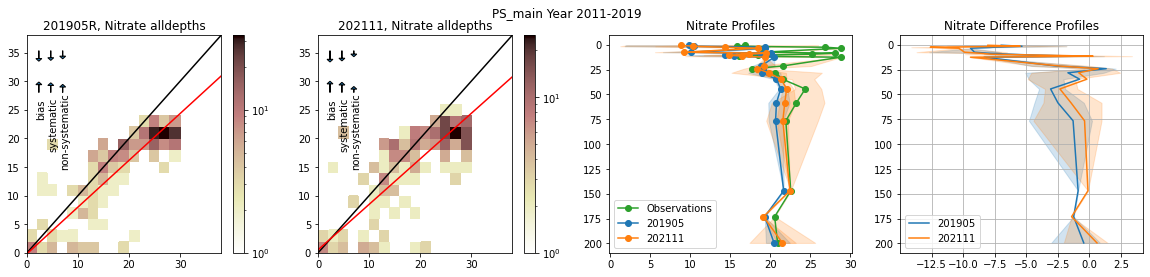

In [98]:
idepth = 0
jdepth = 39
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], [],
               idepth, jdepth, PS_main, 'PS_main', 'alldepths')

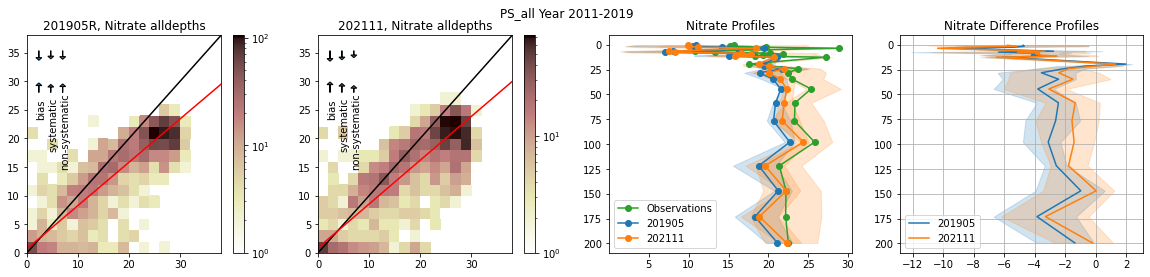

In [99]:
idepth = 0
jdepth = 39
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017, 2018], [], [],
               idepth, jdepth, PS_all, 'PS_all', 'alldepths')

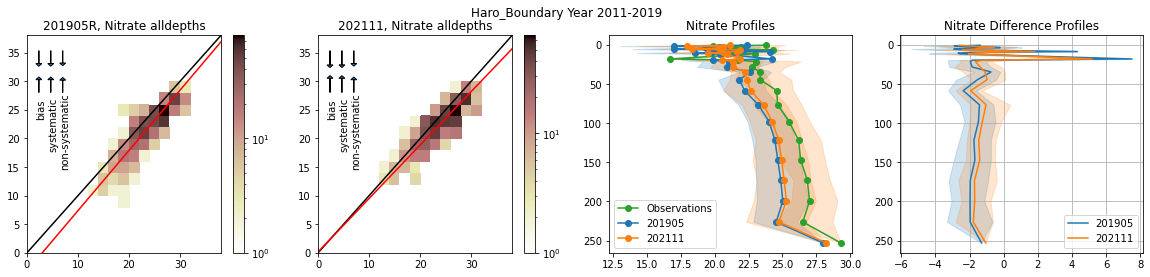

In [100]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], [],
               idepth, jdepth, Haro_Boundary, 'Haro_Boundary', 'alldepths')

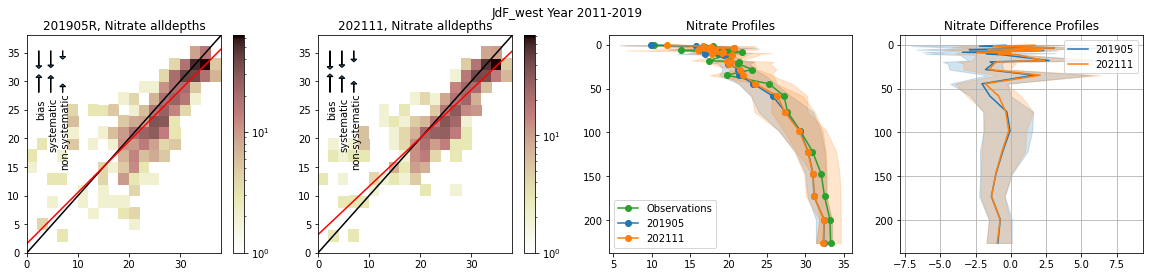

In [101]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], [],
               idepth, jdepth, JdF_west, 'JdF_west', 'alldepths')

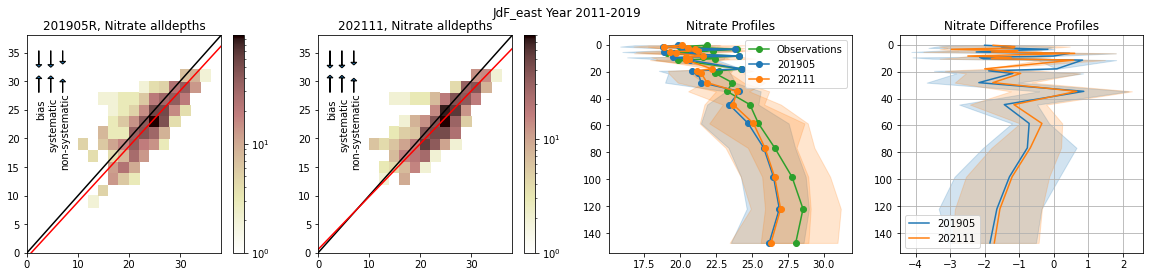

In [102]:
stats_and_plot([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], [],
               idepth, jdepth, JdF_east, 'JdF_east', 'alldepths')

## Above 5 m

In [103]:
idepth = 0
jdepth = 5

number, results = stats_allregions([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], 
                           [],
                           idepth, jdepth, 'top5m')
for boxname in boxnames:
    if number > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3059,-0.631,6.19,6.16,0.119,0.165,1.47,1.75,5.51,0.236
202111,3056,-0.496,5.85,5.83,0.116,0.249,2.67,2.51,4.75,0.366


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,130,-1.51,4.14,3.85,0.0687,0.0511,-0.587,1.57,3.73,0.102
202111,130,-1.17,3.82,3.64,0.0671,0.191,2.3,1.96,3.01,0.333


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,331,0.543,5.68,5.65,0.09,0.0801,1.32,0.964,5.39,0.13
202111,331,0.424,4.9,4.88,0.0765,0.214,2.5,2.17,4.0,0.353


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,260,0.298,6.01,6.0,0.11,0.0739,1.16,0.765,5.75,0.125
202111,260,1.5,5.87,5.68,0.115,0.189,3.71,2.34,4.95,0.299


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,121,-6.18,7.76,4.69,0.176,0.177,-3.25,6.41,4.04,0.288
202111,121,-6.85,8.74,5.43,0.226,0.267,-2.42,7.31,4.28,0.403


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,116,-2.55,3.88,2.93,0.16,-0.18,-6.27,2.68,3.1,-0.521
202111,116,-1.68,3.13,2.64,0.132,0.0714,-0.212,1.71,2.54,-0.0588


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,136,-1.36,7.76,7.64,0.405,0.464,6.88,3.63,5.82,0.356
202111,136,-0.374,5.79,5.78,0.255,0.49,8.33,3.58,3.85,0.6


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,206,-1.57,3.56,3.19,0.228,-0.13,-4.34,1.64,3.38,-0.251
202111,206,-1.31,3.17,2.89,0.21,0.105,0.914,1.37,2.72,0.104


## Below 5 m

In [104]:
idepth = 5
jdepth = 39

number, results = stats_allregions([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                                          , [2015] # 2016 and 2017 have bad nutrient data
                                          , [2015, 2016, 2017], [], 
                           [],
                           idepth, jdepth, 'below5m')
for boxname in boxnames:
    if number > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,11835,-1.27,3.68,3.45,0.0886,0.114,1.5,1.48,3.19,0.184
202111,11835,-0.987,3.42,3.28,0.0795,0.153,2.73,1.42,2.91,0.25


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,701,-1.76,2.75,2.12,0.127,-0.0344,-2.6,1.76,2.15,-0.059
202111,701,-1.48,2.47,1.98,0.111,0.0642,0.0881,1.5,1.9,0.102


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1785,-1.11,3.1,2.9,0.0688,0.118,1.91,1.34,2.65,0.192
202111,1785,-0.795,2.93,2.82,0.0617,0.129,2.51,1.15,2.54,0.217


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,967,-0.575,3.26,3.21,0.112,0.272,6.29,1.66,2.5,0.395
202111,967,-0.31,3.06,3.04,0.0999,0.292,7.07,1.7,2.25,0.445


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,275,-2.51,5.43,4.81,0.225,0.386,5.21,3.7,3.43,0.515
202111,275,-1.83,5.77,5.47,0.273,0.464,7.44,3.73,3.73,0.556


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,630,-1.8,2.57,1.84,0.126,-0.0108,-2.06,1.8,1.85,-0.0362
202111,630,-1.36,2.29,1.84,0.111,0.0859,0.728,1.39,1.75,0.138


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,850,-1.13,4.25,4.1,0.113,0.0924,1.34,1.29,3.88,0.17
202111,850,-0.937,3.6,3.47,0.0822,0.129,2.53,1.29,3.16,0.241


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,830,-1.52,2.98,2.56,0.135,0.0387,-0.564,1.53,2.51,0.0585
202111,830,-1.27,2.64,2.31,0.109,0.0743,0.564,1.31,2.21,0.122
